In [1]:
#!pip install wordcloud

In [2]:
import string
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib

plt.style.use('seaborn')
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [3]:
trainDF = pd.read_csv('data/train.csv')
testDF = pd.read_csv('data/test.csv')

In [4]:
trainDF.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


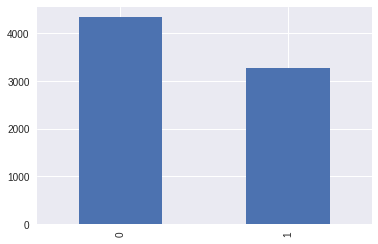

In [5]:
trainDF['target'].value_counts().plot.bar();

In [6]:
trainDF.dropna()['keyword'].value_counts()[:5], testDF.dropna()['keyword'].value_counts()[:5]

(collision     36
 whirlwind     33
 armageddon    32
 fatalities    32
 flames        31
 Name: keyword, dtype: int64,
 survivors      17
 snowstorm      17
 demolished     16
 electrocute    16
 rubble         16
 Name: keyword, dtype: int64)

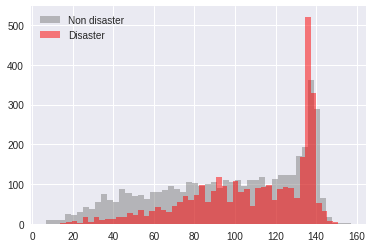

In [7]:
def countWords(sentence):
    count = len(sentence)

    return count
trainDF['len'] = trainDF['text'].map(countWords)
plt.hist(trainDF[trainDF['target']==0]['len'],alpha = 0.5, color = 'grey', label = 'Non disaster', bins = 50)
plt.hist(trainDF[trainDF['target'] == 1]['len'], alpha = 0.5,color = 'r', label = 'Disaster', bins = 50)
plt.legend()
plt.show()

In [8]:
len(trainDF['text'][0].split())

13

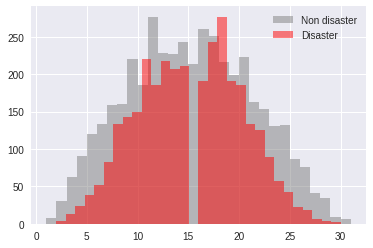

In [9]:
def wordCount(sentence):
    count = len(sentence.split())
    return count
trainDF['NumWords'] = trainDF['text'].map(wordCount)
plt.hist(trainDF[trainDF['target'] == 0]['NumWords'], color = 'grey', alpha = 0.5, label = 'Non disaster', bins = 30)
plt.hist(trainDF[trainDF['target'] == 1]['NumWords'], color = 'r', alpha = 0.5, label = 'Disaster', bins = 30)
plt.legend()
plt.show()


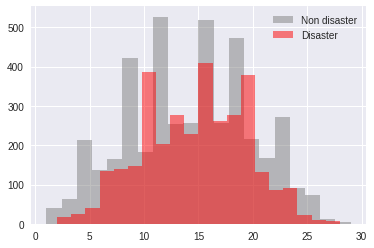

In [10]:
def uniqueWordsCnt(sentence):
    count = len(set(sentence.split()))
    return count

trainDF['numUnique'] = trainDF['text'].map(uniqueWordsCnt)

plt.hist(trainDF[trainDF['target'] == 0]['numUnique'], color = 'grey', alpha = 0.5, label = 'Non disaster', bins = 20)
plt.hist(trainDF[trainDF['target'] == 1]['numUnique'], color = 'r', alpha = 0.5, label = 'Disaster', bins = 20)
plt.legend()
plt.show()

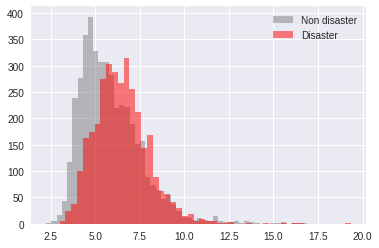

In [11]:
def meanWordLength(sentence):
    lengths = [len(word) for word in sentence.split()]
    return np.mean(lengths)
trainDF['meanLength'] = trainDF['text'].map(meanWordLength)
plt.hist(trainDF[trainDF['target'] == 0]['meanLength'], color = 'grey', alpha = 0.5, label = 'Non disaster', bins = 50)
plt.hist(trainDF[trainDF['target'] == 1]['meanLength'], color = 'r', alpha = 0.5, label = 'Disaster', bins = 50)
plt.legend()
plt.show()

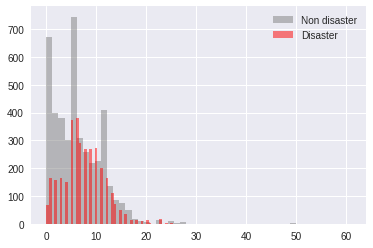

In [12]:
import string

trainDF["punctuationCnt"] = trainDF["text"].map(
    lambda x: len([c for c in str(x) if c in string.punctuation])
)

plt.hist(trainDF[trainDF['target'] == 0]['punctuationCnt'], color = 'grey', alpha = 0.5, label = 'Non disaster', bins = 50)
plt.hist(trainDF[trainDF['target'] == 1]['punctuationCnt'], color = 'r', alpha = 0.5, label = 'Disaster', bins = 50)
plt.legend()
plt.show()


In [13]:
def generate_ngrams(text, n_gram=1, stop=True):
    """
    Simple n-gram generator.
    """
    stop = set(stopwords.words("english")) if stop else {}

    token = [
        token for token in text.lower().split(" ") if token != "" if token not in stop
    ]
    z = zip(*[token[i:] for i in range(n_gram)])
    ngrams = [" ".join(ngram) for ngram in z]

    return ngrams

In [14]:
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

In [15]:
for text in trainDF[trainDF.target == 1].text:
    for word in generate_ngrams(text):
        disaster_unigrams[word] += 1

for text in trainDF[trainDF.target == 0].text:
    for word in generate_ngrams(text):
        nondisaster_unigrams[word] += 1

In [16]:
df_disaster_unigrams = pd.DataFrame(
    sorted(disaster_unigrams.items(), key = lambda x: x[1], reverse=True)
)
df_nondisaster_unigrams = pd.DataFrame(
    sorted(nondisaster_unigrams.items(), key = lambda x:x[1], reverse=True)
)

In [17]:
df_disaster_unigrams.head()

,0,1
0,-,389
1,fire,150
2,via,117
3,&amp;,105
4,...,105


In [18]:
df_disaster_unigrams.columns

RangeIndex(start=0, stop=2, step=1)

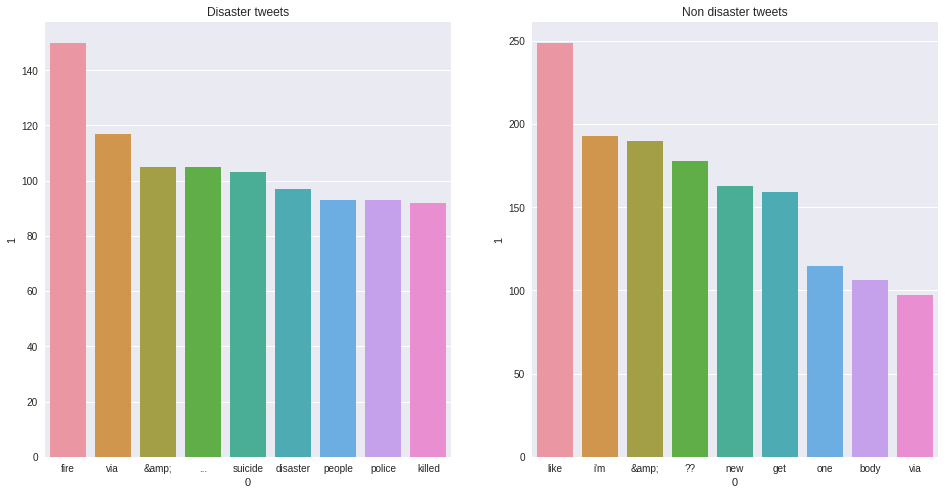

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (16,8))
ax[0].set_title('Disaster tweets')
sns.barplot(x = df_disaster_unigrams.iloc[1:10,0],y = df_disaster_unigrams.iloc[1:10,1], ax = ax[0])
ax[1].set_title('Non disaster tweets')
sns.barplot(x = df_nondisaster_unigrams.iloc[1:10,0],y = df_nondisaster_unigrams.iloc[1:10,1],ax = ax[1])
plt.show()

/home/rodrigo/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


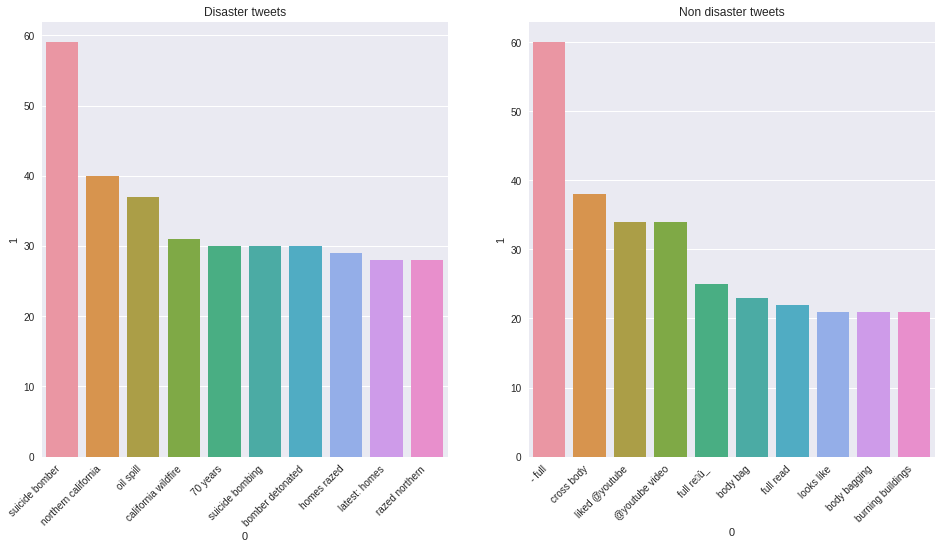

In [20]:
disasterBigrams = defaultdict(int)
nonDisasterBigrams = defaultdict(int)

for text in trainDF[trainDF.target == 1].text:
    for word in generate_ngrams(text, n_gram=2):
        disasterBigrams[word] += 1

for text in trainDF[trainDF.target == 0].text:
    for word in generate_ngrams(text, n_gram=2):
        nonDisasterBigrams[word] += 1

dfDisasterBigrams = pd.DataFrame(
    sorted(disasterBigrams.items(), key=lambda x:x[1], reverse=True)
)
dfNonDisasterBigrams = pd.DataFrame(
    sorted(nonDisasterBigrams.items(), key = lambda x: x[1], reverse=True)
)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (16,8))
ax[0].set_title('Disaster tweets')
labels = ax[0].get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
sns.barplot(x = dfDisasterBigrams.iloc[:10,0],y = dfDisasterBigrams.iloc[:10,1], ax = ax[0])
ax[1].set_title('Non disaster tweets')
labels = ax[1].get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
sns.barplot(x = dfNonDisasterBigrams.iloc[:10,0],y = dfNonDisasterBigrams.iloc[:10,1],ax = ax[1])
plt.show();

In [21]:
def get_top_text_ngrams(corpus, ngrams=(1, 1), nr=None):
    """
    Creates a bag of ngrams and counts ngram frequency.
    
    Returns a sorted list of tuples: (ngram, count)
    """
    vec = CountVectorizer(ngram_range=ngrams).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:nr]

In [22]:
top_text_bigrams = get_top_text_ngrams(trainDF.text, ngrams=(2, 2), nr=10)
top_text_bigrams

[('http co', 4306),
 ('https co', 410),
 ('in the', 308),
 ('of the', 256),
 ('û_ http', 217),
 ('on the', 129),
 ('to the', 126),
 ('to be', 108),
 ('for the', 97),
 ('at the', 85)]

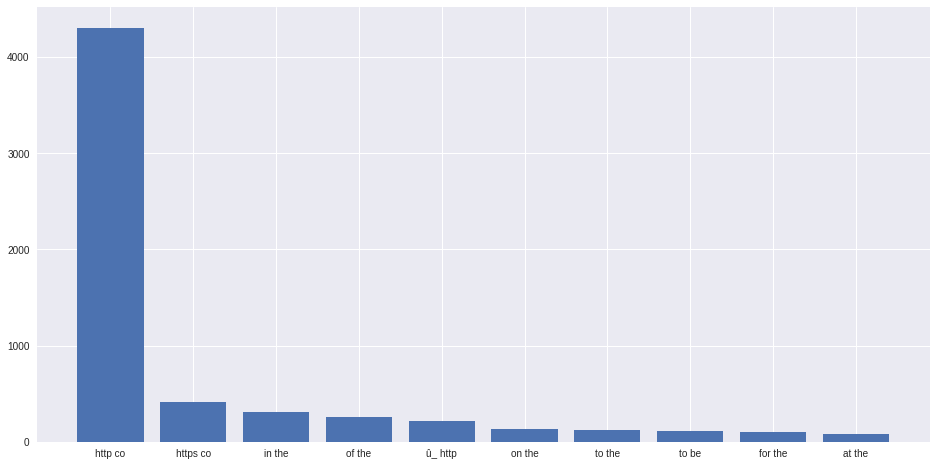

In [23]:
x, y = zip(*top_text_bigrams)
plt.figure(1, figsize=(16, 8))
plt.subplot(1, 1, 1)
plt.bar(x, y);

In [24]:
def createCorpus(text):
    words = []
    for texts in text.str.split():
        for word in texts:
            words.append(word)
    return words

In [25]:
nonDisasterCorpus = createCorpus(trainDF[trainDF['target'] == 0]['text'])
disasterCorpus = createCorpus(trainDF[trainDF['target'] == 1]['text'])

stop = set(stopwords.words('english'))
d0 = defaultdict(int)
d1 = defaultdict(int)

for word in nonDisasterCorpus:
    if word in stop:
        d0[word] += 1

for word in disasterCorpus:
    if word in stop:
        d1[word] += 1

In [26]:
topDisaster = sorted(d1.items(), key = lambda x: x[1], reverse=True)[:10]
topNonDisaster = sorted(d0.items(), key = lambda x: x[1], reverse=True)[:10]

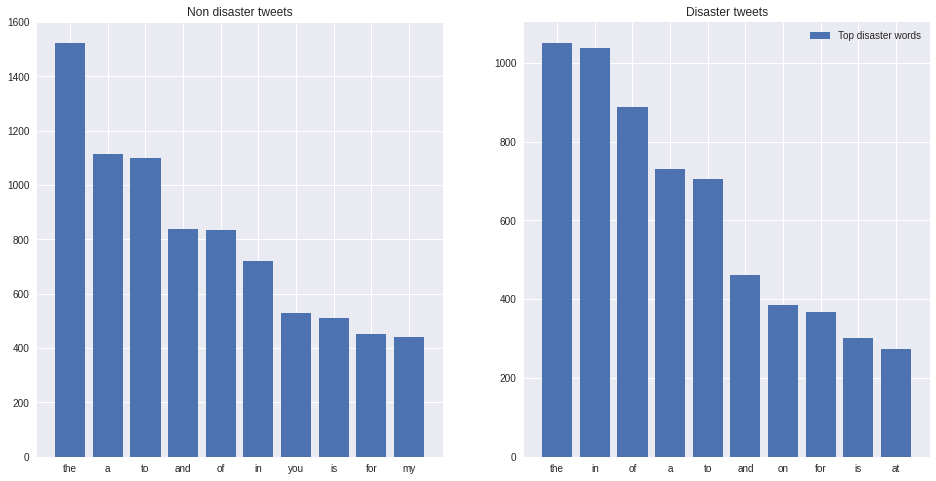

In [27]:
X0 , Y0 = zip(*topNonDisaster)
X1, Y1 = zip(*topDisaster)
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('Non disaster tweets')
plt.bar(x = X0, height=Y0, label = 'Top non disaster words')
plt.subplot(1,2,2)
plt.title('Disaster tweets')
plt.bar(x = X1, height=Y1, label = 'Top disaster words')
plt.legend()
plt.show()

In [28]:
punc0 = defaultdict(int)
for word in nonDisasterCorpus:
    if word in string.punctuation:
        punc0[word] += 1

punc1 = defaultdict(int)
for word in disasterCorpus:
    if word in string.punctuation:
        punc1[word] += 1

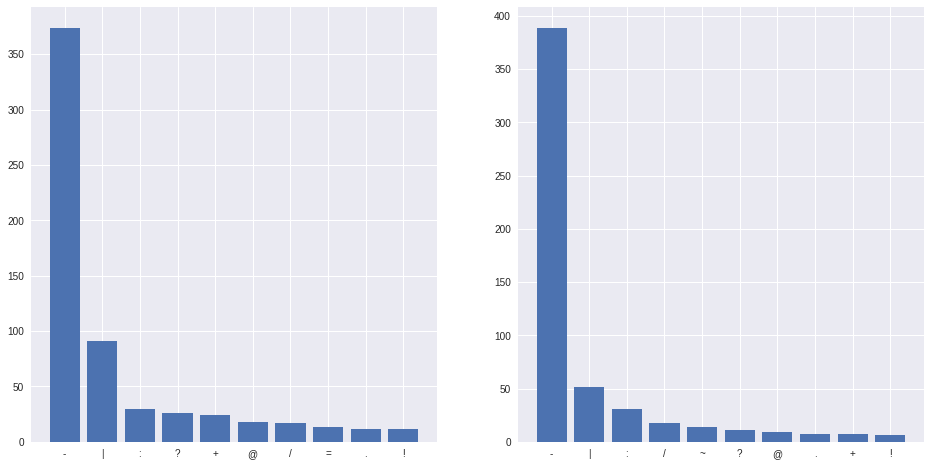

In [29]:
top0 = sorted(punc0.items(), key=lambda x: x[1], reverse=True)[:10]
top1 = sorted(punc1.items(), key=lambda x: x[1], reverse=True)[:10]

x0, y0 = zip(*top0)
x1, y1 = zip(*top1)

plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.bar(x0, y0)
plt.subplot(1, 2, 2)
plt.bar(x1, y1);

In [30]:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

In [31]:
trainDF["text"] = trainDF.text.map(lambda x: remove_URL(x))
trainDF["text"] = trainDF.text.map(lambda x: remove_html(x))
trainDF["text"] = trainDF.text.map(lambda x: remove_emoji(x))
trainDF["text"] = trainDF.text.map(lambda x: remove_punct(x))

In [32]:
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)
trainDF["text"] = trainDF["text"].map(remove_stopwords)

In [33]:
corpus0 = createCorpus(trainDF[trainDF['target']== 0]['text'])
corpus1 = createCorpus(trainDF[trainDF['target'] == 1]['text'])


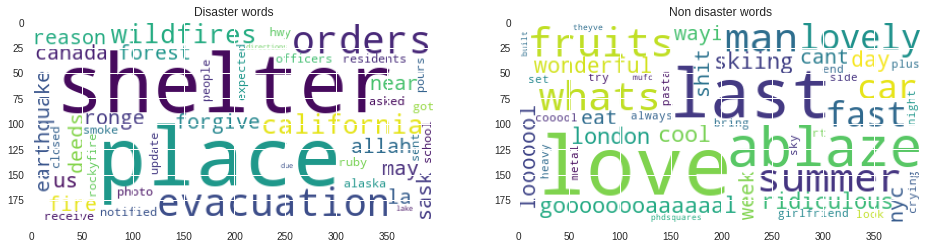

In [34]:
word_cloud0 = WordCloud(background_color="white", max_font_size=80).generate(
    " ".join(corpus0[:50])
)
word_cloud1 = WordCloud(background_color="white", max_font_size=80).generate(
    " ".join(corpus1[:50])
)

plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Disaster words')
plt.imshow(word_cloud1)
plt.subplot(1, 2, 2)
plt.title('Non disaster words')
plt.imshow(word_cloud0);

In [35]:
def stemming(text):
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in text.split()]

    return " ".join(text)

In [36]:
trainDF["text"] = trainDF["text"].map(stemming)

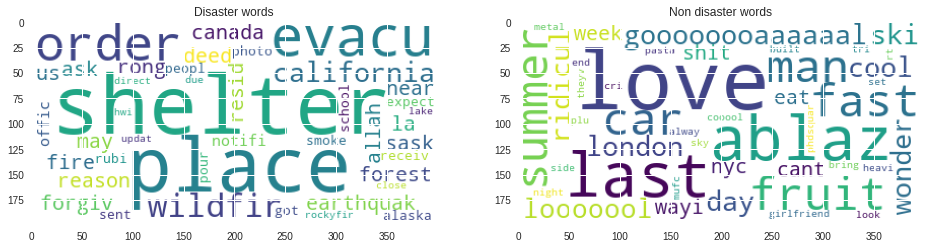

In [37]:
corpus0 = createCorpus(trainDF[trainDF['target']== 0]['text'])
corpus1 = createCorpus(trainDF[trainDF['target'] == 1]['text'])

word_cloud0 = WordCloud(background_color="white", max_font_size=80).generate(
    " ".join(corpus0[:50])
)
word_cloud1 = WordCloud(background_color="white", max_font_size=80).generate(
    " ".join(corpus1[:50])
)

plt.figure(1, figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Disaster words')
plt.imshow(word_cloud1)
plt.subplot(1, 2, 2)
plt.title('Non disaster words')
plt.imshow(word_cloud0);


### Second part

In [38]:
train = pd.read_csv(f"data/train.csv")
test = pd.read_csv(f"data/test.csv")

In [39]:
train["text"] = train.text.map(lambda x: remove_URL(x))
train["text"] = train.text.map(lambda x: remove_html(x))
train["text"] = train.text.map(lambda x: remove_emoji(x))
train["text"] = train.text.map(lambda x: remove_punct(x))
train['text'] = train['text'].map(remove_stopwords)

In [40]:
tokenizer = TreebankWordTokenizer()

train['tokens'] = train['text'].map(tokenizer.tokenize)
train[['text','tokens']].head(10)

,text,tokens
0,deeds reason earthquake may allah forgive us,"[deeds, reason, earthquake, may, allah, forgiv..."
1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,residents asked shelter place notified officer...,"[residents, asked, shelter, place, notified, o..."
3,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,got sent photo ruby alaska smoke wildfires pou...,"[got, sent, photo, ruby, alaska, smoke, wildfi..."
5,rockyfire update california hwy 20 closed dire...,"[rockyfire, update, california, hwy, 20, close..."
6,flood disaster heavy rain causes flash floodin...,"[flood, disaster, heavy, rain, causes, flash, ..."
7,im top hill see fire woods,"[im, top, hill, see, fire, woods]"
8,theres emergency evacuation happening building...,"[theres, emergency, evacuation, happening, bui..."
9,im afraid tornado coming area,"[im, afraid, tornado, coming, area]"


In [41]:
def count_vect(data, ngrams=(1, 1)):
    count_vectorizer = CountVectorizer(ngram_range=ngrams)
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [42]:
train_counts, count_vectorizer = count_vect(train["text"])
test_counts = count_vectorizer.transform(test["text"])

In [43]:
train.text.iloc[0]

'deeds reason earthquake may allah forgive us'

In [44]:
train_counts, count_vectorizer = count_vect(train["text"], ngrams=(1, 1))
test_counts = count_vectorizer.transform(test["text"])

print(train_counts.todense()[0][0:].sum())

7


In [45]:
def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


train_tfidf, tfidf_vectorizer = tfidf(train["text"])
test_tfidf = tfidf_vectorizer.transform(test["text"])

In [46]:
[x for x in train_tfidf.todense()[0][0:].tolist()[0] if x != 0]

[0.40602120282994775,
 0.47004586769653584,
 0.32603762602820663,
 0.47004586769653584,
 0.2909803719918841,
 0.3665665825282047,
 0.2606134637318126]

In [47]:
X_counts = train_counts
X_tfidf = train_tfidf
y = train["target"].values

In [48]:
def plot_LSA(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ["orange", "blue", "blue"]
    if plot:
        plt.scatter(
            lsa_scores[:, 0],
            lsa_scores[:, 1],
            s=8,
            alpha=0.8,
            c=test_labels,
            cmap=matplotlib.colors.ListedColormap(colors),
        )
        red_patch = mpatches.Patch(color="orange", label="Irrelevant")
        green_patch = mpatches.Patch(color="blue", label="Disaster")
        plt.legend(handles=[red_patch, green_patch], prop={"size": 16})

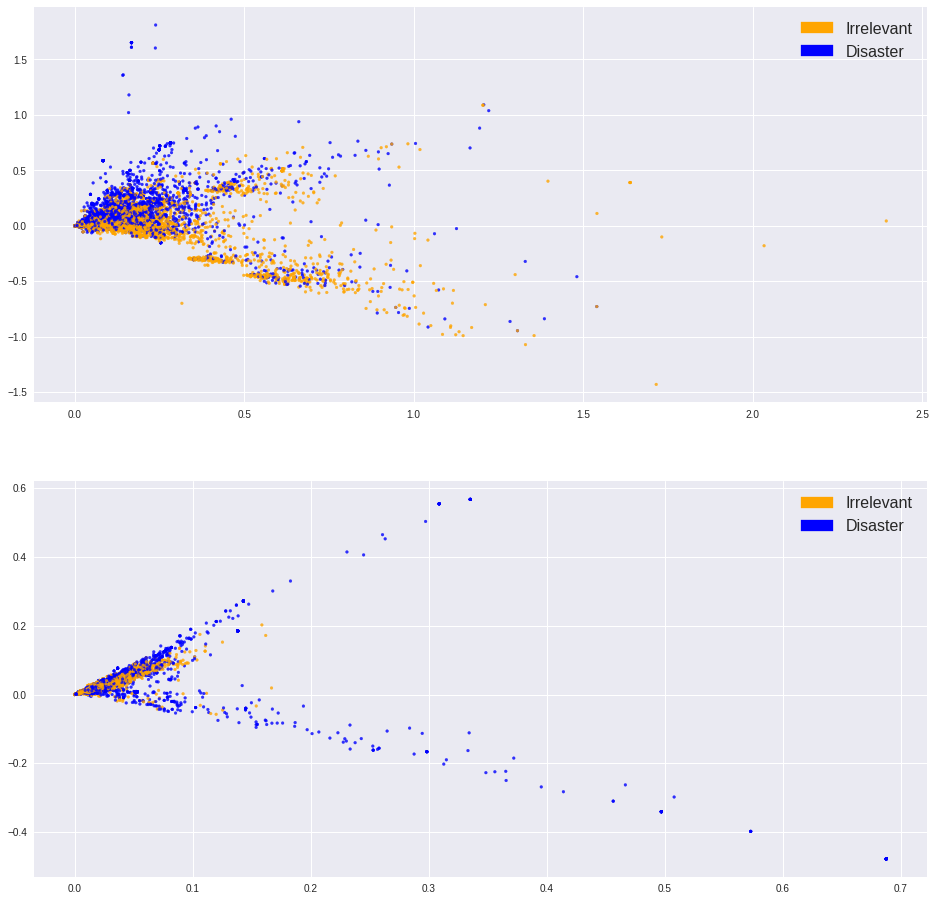

In [49]:
plt.figure(1, figsize=(16, 16))
plt.subplot(2, 1, 1)
plot_LSA(X_counts, y)
plt.subplot(2, 1, 2)
plot_LSA(X_tfidf, y)

In [50]:
X = train_counts
y = train["target"].values

X_train_counts, X_test, y_train_counts, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)

In [51]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_counts, y_train_counts)

LogisticRegression(class_weight='balanced')

In [52]:
y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred)
print(f"Counts Model Score: {f1score * 100} %")

Counts Model Score: 76.58574784651528 %


In [53]:
X = train_tfidf
y = train["target"].values

X_train_tfidf, X_test, y_train_tfidf, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)

In [54]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_tfidf, y_train_tfidf)

LogisticRegression(class_weight='balanced')

In [55]:
y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred)
print(f"Tfidf Model Score: {f1score * 100} %")

Tfidf Model Score: 76.64576802507837 %
